In [7]:
import os, random
import numpy as np
import torch

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


df = pd.read_csv('games_march2025_cleaned_NEW.csv')
print(f"Total games: {len(df)}")


Total games: 72563


In [9]:
#calculate the standard result
#get estimated owners
owners = df["estimated_owners"].astype(float)
N = len(df)

#rank+percentile
owners_rank = owners.rank(method="first") / N

#define thresholds (same from kclass)
q1 = 0.25
q2 = 0.75

def make_pop_class(r):
    if r <= q1:
        return 0    # low
    elif r >= q2:
        return 2    # high
    else:
        return 1    # medium


df["pop_class"] = owners_rank.apply(make_pop_class)

print(df["pop_class"].value_counts())


pop_class
1    36282
2    18141
0    18140
Name: count, dtype: int64


In [10]:
from sklearn.preprocessing import MultiLabelBinarizer
import re

num_features = ['price', 'dlc_count', 'achievements', 'required_age']
cat_cols = ['supported_languages','categories','genres']

# Here to add categortical data into our input
# retrieve the categorical data and put them into a list
def split_to_list(x):
    # make it a lowercase string so "RPG" and "rpg" become the same
    s = str(x).lower()
    # split using ,
    parts = re.split(r",", s)
    return parts

cat_lists = []

# loop through rows of the dataframe
for i, row in df.iterrows():
    toks = []
    # loop through each categorical column we care about
    for c in cat_cols:
        # split that cell into tokens and add them into this row's token list
        toks.extend(split_to_list(row[c]))

    # creating a list of all the categories needed
    cat_lists.append(toks)


#Multi-hot encode using the mlb function
mlb = MultiLabelBinarizer()
# creates a matrix that we need which could be appended to the original numerical data
X_cat = mlb.fit_transform(cat_lists).astype(np.float32)

print("Categorical one-hot dims:", X_cat.shape[1])

# Merge categorical and numerical data
scaler = StandardScaler()
X_num_raw = df[num_features].fillna(0).values
X_num = scaler.fit_transform(X_num_raw).astype(np.float32)

X_all = np.hstack([X_num, X_cat]).astype(np.float32)
y = df['pop_class'].values

X = torch.tensor(X_all, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train size: {len(X_train)}")


Categorical one-hot dims: 460
Train size: 58050


In [11]:
#model architecture
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.sig(self.fc1(x))
        x = self.sig(self.fc2(x))
        return self.out(x)

model = Net(input_dim=X.shape[1], output_dim=3) #newly added
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

Net(
  (fc1): Linear(in_features=464, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=3, bias=True)
  (sig): Sigmoid()
)


Epoch 5/50 | Acc: 0.5992 | Train Loss: 0.9001
Epoch 10/50 | Acc: 0.5994 | Train Loss: 0.8923
Epoch 15/50 | Acc: 0.5977 | Train Loss: 0.8860
Epoch 20/50 | Acc: 0.6023 | Train Loss: 0.8809
Epoch 25/50 | Acc: 0.6039 | Train Loss: 0.8749
Epoch 30/50 | Acc: 0.6021 | Train Loss: 0.8695
Epoch 35/50 | Acc: 0.6039 | Train Loss: 0.8644
Epoch 40/50 | Acc: 0.6041 | Train Loss: 0.8591
Epoch 45/50 | Acc: 0.6050 | Train Loss: 0.8535
Epoch 50/50 | Acc: 0.6046 | Train Loss: 0.8471


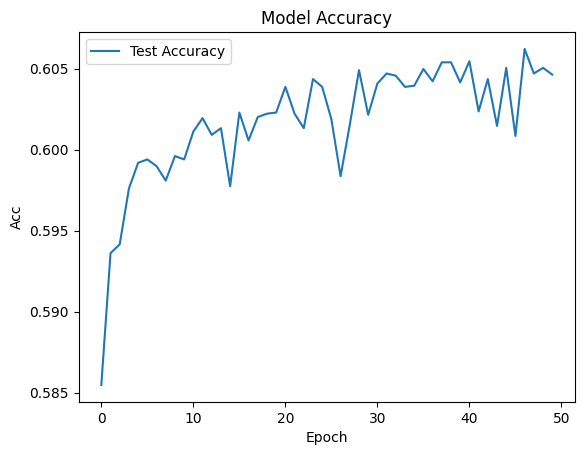

Final Acc: 0.6046
Final Train Loss: 0.8471


In [12]:
epochs = 50
train_acc_history = []
train_loss_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    n_train = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()


        bs = X_batch.size(0)
        running_loss += loss.item() * bs
        n_train += bs

    avg_train_loss = running_loss / n_train
    train_loss_history.append(avg_train_loss)

    model.eval()
    correct = 0
    with torch.no_grad():
        for X_b, y_b in test_loader:
            out = model(X_b)
            pred = out.argmax(dim=1)
            correct += (pred == y_b).sum().item()

    acc = correct / len(test_dataset)
    train_acc_history.append(acc)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs} | Acc: {acc:.4f} | Train Loss: {avg_train_loss:.4f}')
# Plot
plt.plot(train_acc_history, label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()

print(f'Final Acc: {train_acc_history[-1]:.4f}')
print(f'Final Train Loss: {train_loss_history[-1]:.4f}')